100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


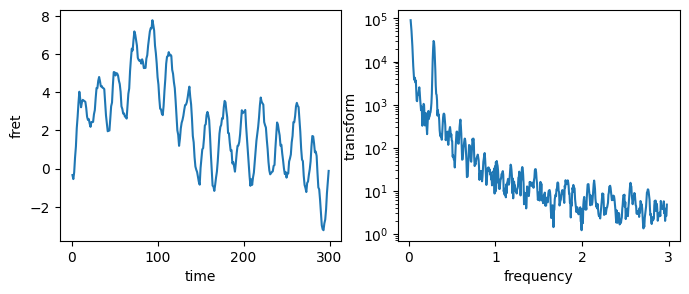

In [12]:
"""
This is code for an Expanding Window Fourier Transform. It accepts a Pandas dataframe with 
columns 'time','fret',and 'fov'. 'time' represents a time point, 'fret' represents the FRET
ratio at that time point, and 'fov' can represent a single field of view or a segmented cell. 
"""
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def closest(lst, K):
     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
def simplify(a,b,dataframe):
    dataframe3 = pd.DataFrame({a:[],b:[]})
    fs = dataframe[a].unique()
    for x in fs:
        dataframe2 = dataframe[dataframe[a]==x]
        dataframe3.loc[len(dataframe3.index)] = [x,dataframe2[b].mean()]
    return dataframe3



trunc = 0 #If you want to truncate your data at the beginning, set this value to >0. 
wsize = 50 #Smallest window size to transform. This is something you want to experiment with. 
sampling_freq = 6 #Sampling frequency. 6 represents a sampling frequency of 6 times per hour.

## 
trace = [0]
for i in range(1,300):
    trace.append(trace[i-1] + np.random.rand()-0.5 + 0.5*np.sin(0.3*i)) 
df = pd.DataFrame({'time':np.arange(300),'fret':trace,'fov':[0]*300})
## For demonstrative purposes I've generated a Brownian noised sine function

#df = pd.read_csv('fret.csv') 
df = df[df['time']>trunc]
df['time']-=trunc
nslide = int(df['time'].max()+1-wsize) #Number expansions to transform over. 
bins = np.arange(0,3,0.005) #Frequency bins to assign transform data to after all expansions. This is to your taste. 

with tqdm(total=df['fov'].nunique()) as pbar:
    for i in df['fov'].unique():
        df2 = df[df['fov']==i]
        for j in range(nslide):
            df3 = df2[df2['time'].between(0,wsize+j)] #Establish a window to transform. 
            ft = abs(np.fft.fft(df3['fret']))**2 #Get square modulus of Fourier coefficients. 
            ft = ft[:int(len(ft)/2)] #Keep only half the data, because it's symmetric about the Nyquist limit.
            fs = np.arange(len(ft))/len(ft)*sampling_freq/2 #Format output frequencies based on sampling frequency. 

            if((j)==0):
                fdf = pd.DataFrame({'frequency':fs,'transform':ft,'fov':[i]*len(ft)})
            else:
                fdf2 = pd.DataFrame({'frequency':fs,'transform':ft,'fov':[i]*len(ft)})
                fdf = pd.concat([fdf,fdf2])
        fdf['frequency'] = [closest(bins,x) for x in fdf['frequency']] #Bin frequencies
        fdf = simplify('frequency','transform',fdf) #Take the mean transform magnitude of degenerate frequencies.
        fdf['fov'] = [i]*len(fdf)
        if(i==0):
            pdf = fdf.copy()
        else:
            pdf = pd.concat([pdf,fdf])
        
        pbar.update(1)

pdf = pdf.sort_values(by=['frequency','fov'])
pdf = pdf[pdf['frequency']>0.01] #Optional. Unsubtracted time traces produce spectra that have very high values at f = 0. 

plt.rcParams["figure.figsize"]=8,3
fig, ax = plt.subplots(ncols=2)
sns.lineplot(data=df,x='time',y='fret',ax=ax[0])
sns.lineplot(data=pdf,x='frequency',y='transform',ax=ax[1])
ax[1].set_yscale('log')
#pdf.to_csv('fourier.csv',index=None)